In [6]:
import os, json, time, pickle, shutil
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, grad, value_and_grad, vmap
import flax
import flax.linen as nn
from flax.training import train_state
from flax.linen.initializers import glorot_normal, zeros, normal
import optax
import ml_collections
import orbax.checkpoint as ocp
jran = jax.random
import matplotlib.pyplot as plt

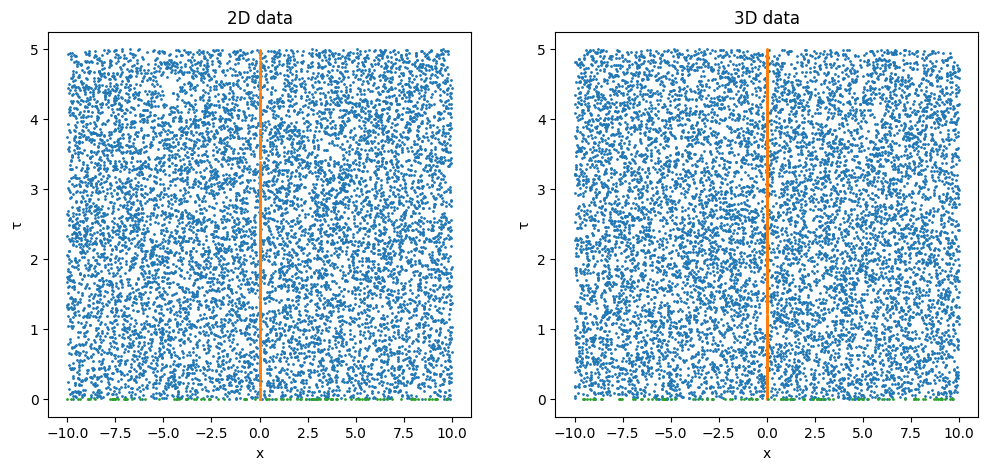

In [7]:
def get_data_2d(n_pde=10000, n_bc=500, n_term=100, T=5.0, x_range=(-10.,10.), seed=0):
    rng = np.random.default_rng(seed)
    X_pde = rng.uniform(x_range[0], x_range[1], size=(n_pde, 1))
    tau   = rng.uniform(0, T, size=(n_pde, 1))
    x_tau_pde = np.hstack([tau, X_pde])
    # x=0 boundary along τ
    tau_bc = rng.uniform(0, T, size=(n_bc, 1))
    x_bc   = np.zeros((n_bc, 1))
    x_bc_zero = np.hstack([tau_bc, x_bc])

    # terminal condition
    tau_term = np.zeros((n_term, 1))
    x_term = rng.uniform(x_range[0], x_range[1], size=(n_term, 1))
    x_term_cond = np.hstack([tau_term, x_term])

    return jnp.array(x_tau_pde), jnp.array(x_bc_zero), jnp.array(x_term_cond), T

def get_data_3d(n_pde=10000, n_bc=1000, n_term=100, T=5.0, x_range=(-10.,10.), s_range=(10,100), seed=0):
    rng = np.random.default_rng(seed)
    X_pde = rng.uniform(x_range[0], x_range[1], size=(n_pde, 1))
    S_pde = rng.uniform(s_range[0], s_range[1], size=(n_pde, 1))
    tau   = rng.uniform(0, T, size=(n_pde, 1))
    x_tau_pde = np.hstack([tau, X_pde, S_pde])
    # BC: V(τ,0,S) <= 0
    tau_bc = rng.uniform(0, T, size=(n_bc, 1))
    x_bc   = np.zeros((n_bc, 1))
    S_bc   = rng.uniform(s_range[0], s_range[1], size=(n_bc, 1))
    x_bc_zero = np.hstack([tau_bc, x_bc, S_bc])
    # Terminal at τ=0, x: V=0
    tau_term = np.zeros((n_term, 1))
    S_term   = rng.uniform(s_range[0], s_range[1], size=(n_term, 1))
    x_term   = rng.uniform(x_range[0], x_range[1], size=(n_term, 1))
    x_term_cond = np.hstack([tau_term, x_term, S_term])
    return jnp.array(x_tau_pde), jnp.array(x_bc_zero), jnp.array(x_term_cond), T


data_2d = get_data_2d()
data_3d = get_data_3d()
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(data_2d[0][:,1], data_2d[0][:,0], s=1)
plt.scatter(data_2d[1][:,1], data_2d[1][:,0], s=1)
plt.scatter(data_2d[2][:,1], data_2d[2][:,0], s=1)
plt.title('2D data')
plt.xlabel('x'); plt.ylabel('τ')
plt.subplot(122)
plt.scatter(data_3d[0][:,1], data_3d[0][:,0], s=1)
plt.scatter(data_3d[1][:,1], data_3d[1][:,0], s=1)
plt.scatter(data_3d[2][:,1], data_3d[2][:,0], s=1)
plt.title('3D data')
plt.xlabel('x'); plt.ylabel('τ')
plt.show()
plt.close()

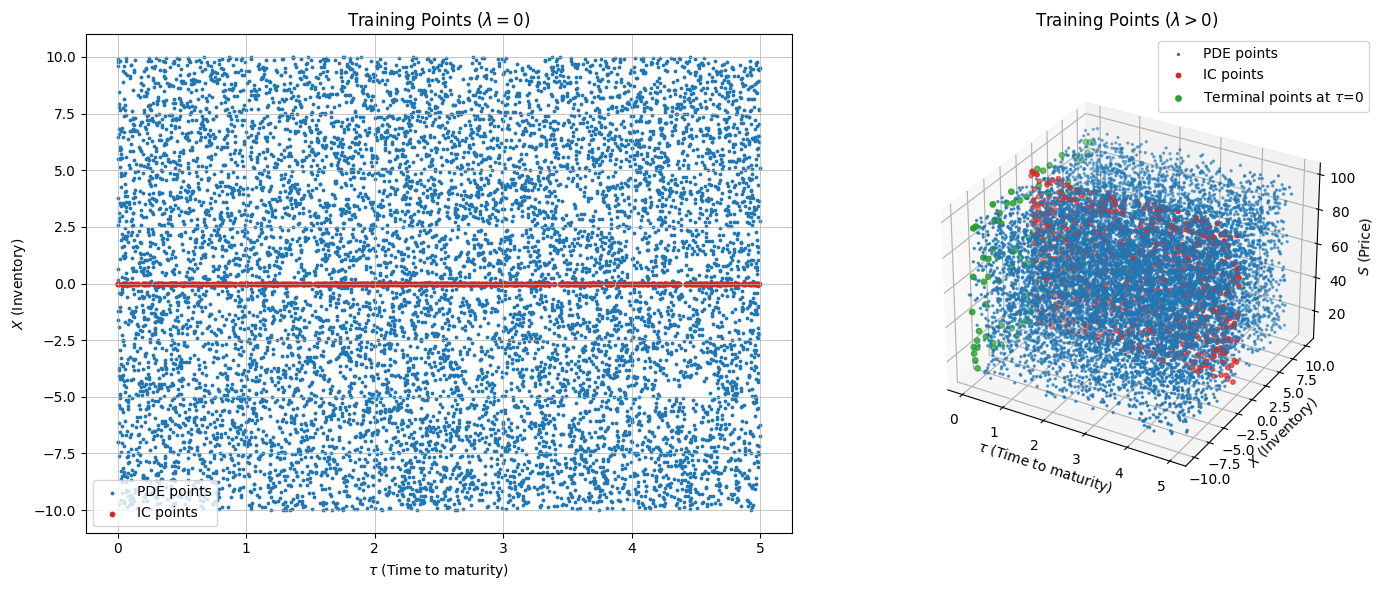

In [23]:
# Generate a single figure with two subplots (2D and 3D side by side)
# Create data
x_tau_pde_2d, x_bc_zero_2d, x_term_cond_2d, T2d = get_data_2d()
x_tau_pde_3d, x_bc_zero_3d, x_term_cond_3d, T3d = get_data_3d()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={})
# Plot 2D
ax1.scatter(np.array(x_tau_pde_2d)[:,0], np.array(x_tau_pde_2d)[:,1], s=3, c="tab:blue", label="PDE points")
ax1.scatter(np.array(x_bc_zero_2d)[:,0], np.array(x_bc_zero_2d)[:,1], s=10, c="tab:red", label="IC points")
ax1.set_title(r"Training Points ($\lambda=0$)")
ax1.set_xlabel(r"$\tau$ (Time to maturity)")
ax1.set_ylabel(r"$X$ (Inventory)")
ax1.legend(loc="lower left")
ax1.grid(True, linewidth=0.5)

# Create 3D subplot manually (since subplots doesn't accept projection='3d' in the same tuple)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig.delaxes(ax2)  # remove placeholder
ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(np.array(x_tau_pde_3d)[:,0], np.array(x_tau_pde_3d)[:,1], np.array(x_tau_pde_3d)[:,2], 
            s=2, c="tab:blue", label="PDE points")
ax2.scatter(np.array(x_bc_zero_3d)[:,0], np.array(x_bc_zero_3d)[:,1], np.array(x_bc_zero_3d)[:,2], 
            s=10, c="tab:red", label="IC points")
ax2.scatter(np.array(x_term_cond_3d)[:,0], np.array(x_term_cond_3d)[:,1], np.array(x_term_cond_3d)[:,2], 
            s=15, c="tab:green", label=r"Terminal points at $\tau$=0")
ax2.set_title(r"Training Points ($\lambda>0$)")
ax2.set_xlabel(r"$\tau$ (Time to maturity)")
ax2.set_ylabel(r"$X$ (Inventory)")
ax2.set_zlabel(r"$S$ (Price)")
ax2.legend(loc="best")
ax2.set_box_aspect(None, zoom=0.85)

fig.tight_layout()

